# 1_Naive_Bayes_Classifier

In [243]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline

[nltk_data] Downloading package punkt to /home/isjeon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/isjeon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading Data

In [244]:
# Dataset Location : https://www.kaggle.com/uciml/sms-spam-collection-dataset/
mails = pd.read_csv('data/spam.csv', encoding = 'latin-1')
mails.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
mails.rename(columns = {'v1': 'labels', 'v2': 'message'}, inplace = True)
mails.head()

,labels,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [245]:
mails['label'] = mails['labels'].map({'ham': 0, 'spam': 1})
mails.drop(['labels'], axis = 1, inplace = True)
mails.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [246]:
mails['label'].value_counts()

0    4825
1     747
Name: label, dtype: int64

In [247]:
 mails['label'].count()

5572

## Train-Test Split

In [248]:
totalMails = mails.shape[0] #4825 + 747
trainIndex, testIndex = list(), list()

for i in range(totalMails):
    if np.random.uniform(0,1) < 0.75:
        trainIndex += [i]
    else:
        testIndex += [i]

trainData = mails.loc[trainIndex]
testData = mails.loc[testIndex]

In [249]:
trainData.reset_index(inplace = True)
trainData.drop(['index'], axis = 1, inplace = True)
trainData.head()

,message,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [250]:
trainData['label'].value_counts()

0    3634
1     558
Name: label, dtype: int64

In [251]:
testData.reset_index(inplace = True)
testData.drop(['index'], axis = 1, inplace = True)
testData.head()

,message,label
0,FreeMsg Hey there darling it's been 3 week's n...,1
1,WINNER!! As a valued network customer you have...,1
2,Had your mobile 11 months or more? U R entitle...,1
3,"SIX chances to win CASH! From 100 to 20,000 po...",1
4,Oh k...i'm watching here:),0


In [252]:
testData['label'].value_counts()

0    1191
1     189
Name: label, dtype: int64

## Visualization

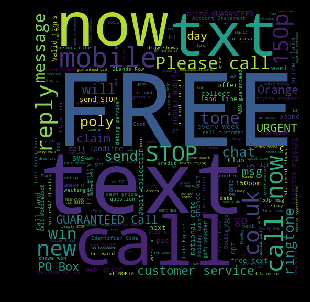

In [253]:
spam_words = ' '.join(list(mails[mails['label'] == 1]['message']))
spam_wc = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (5, 4), facecolor = 'k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

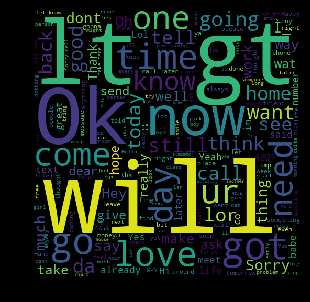

In [254]:
ham_words = ' '.join(list(mails[mails['label'] == 0]['message']))
ham_wc = WordCloud(width = 512,height = 512).generate(ham_words)
plt.figure(figsize = (5, 4), facecolor = 'k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

## Naive-Bayes Classifier

### Training = Learning Parameters

In [255]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 1):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    
    return words

In [256]:
mails, labels = trainData['message'], trainData['label']

spam_mails, ham_mails = labels.value_counts()[1], labels.value_counts()[0]
total_mails = spam_mails + ham_mails # mails.shape[0]

spam_words = 0
ham_words = 0

tf_spam = dict()
tf_ham = dict()

# idf_spam = dict()
# idf_ham = dict()
        
for i in range(total_mails):
    message_processed = process_message(mails[i])
    count = list() #To keep track of whether the word has ocured in the message or not.
                   #For IDF

    for word in message_processed:
        if labels[i] == 1: # SPAM
            tf_spam[word] = tf_spam.get(word, 0) + 1
            spam_words += 1
        else:           # HAM
            tf_ham[word] = tf_ham.get(word, 0) + 1
            ham_words += 1
        if word not in count:
            count += [word]
        
#     for word in count:
#         if labels[i]:
#             idf_spam[word] = idf_spam.get(word, 0) + 1
#         else:
#             idf_ham[word] = idf_ham.get(word, 0) + 1


In [257]:
prob_spam = dict()
prob_ham = dict()

for word in tf_spam:
    prob_spam[word] = (tf_spam[word] + 1) / (spam_words + len(list(tf_spam.keys())))
for word in tf_ham:
    prob_ham[word] = (tf_ham[word] + 1) / (ham_words + len(list(tf_ham.keys())))

prob_spam_mail = spam_mails / total_mails
prob_ham_mail = ham_mails / total_mails 


### Classifier

In [258]:
def classifier(processed_message):
    pSpam, pHam = 0, 0
    for word in processed_message:                

        if word in prob_spam:
            pSpam += log(prob_spam[word])
        else:
            pSpam -= log(spam_words + len(list(prob_spam.keys())))

        if word in prob_ham:
            pHam += log(prob_ham[word])
        else:
            pHam -= log(ham_words + len(list(prob_ham.keys())))

        pSpam += log(prob_spam_mail)
        pHam += log(prob_ham_mail)

    return pSpam >= pHam


In [259]:
pm = process_message('I cant pick the phone right now. Pls send a message')
classifier(pm)

False

In [260]:
pm = process_message('Congratulations ur awarded $500 ')
classifier(pm)

True

In [261]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)

    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [262]:
result = dict()
for (i, message) in enumerate(trainData['message']):
    processed_message = process_message(message)
    result[i] = classify(processed_message)
metrics(trainData['label'], result)

Precision:  0.9533527696793003
Recall:  0.5860215053763441
F-score:  0.7258601553829078
Accuracy:  0.9410782442748091


# Test

In [263]:
result = dict()
for (i, message) in enumerate(testData['message']):
    processed_message = process_message(message)
    result[i] = classify(processed_message)
metrics(testData['label'], result)

Precision:  0.9302325581395349
Recall:  0.42328042328042326
F-score:  0.5818181818181818
Accuracy:  0.9166666666666666
